In [1]:
import cv2
import numpy as np
import pandas as pd
import sys
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt
import os
import shutil
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sn
import json
import joblib 
%matplotlib inline

In [2]:
img = cv2.imread('./test_images/virat.jpg')
img.shape

(344, 260, 3)

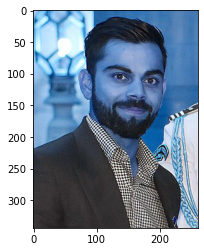

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(344, 260)

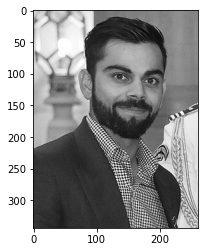

In [5]:
plt.imshow(gray, cmap='gray')

In [6]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 85,  50, 145, 145]], dtype=int32)

In [7]:
(x,y,w,h) = faces[0]
x,y,w,h

(85, 50, 145, 145)

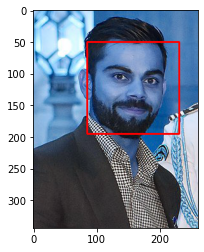

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

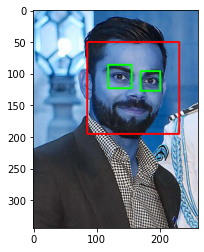

In [9]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

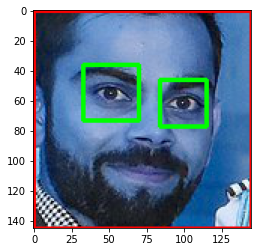

In [10]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [11]:
# wavelength to data
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray, cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [13]:
cropped_img = np.array(roi_color)
cropped_img.shape

(145, 145, 3)

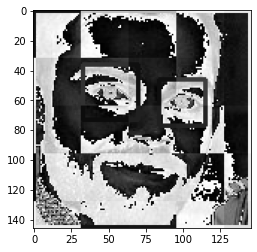

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [16]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [17]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [18]:
img_dirs

['./dataset/cropped',
 './dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

In [19]:
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [20]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
lionel_messi
Generating cropped images in folder:  ./dataset/cropped/lionel_messi
maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
roger_federer
Generating cropped images in folder:  ./dataset/cropped/roger_federer
serena_williams
Generating cropped images in folder:  ./dataset/cropped/serena_williams
virat_kohli
Generating cropped images in folder:  ./dataset/cropped/virat_kohli


In [21]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi\\lionel_messi1.png',
  './dataset/cropped/lionel_messi\\lionel_messi10.png',
  './dataset/cropped/lionel_messi\\lionel_messi11.png',
  './dataset/cropped/lionel_messi\\lionel_messi13.png',
  './dataset/cropped/lionel_messi\\lionel_messi14.png',
  './dataset/cropped/lionel_messi\\lionel_messi15.png',
  './dataset/cropped/lionel_messi\\lionel_messi16.png',
  './dataset/cropped/lionel_messi\\lionel_messi17.png',
  './dataset/cropped/lionel_messi\\lionel_messi18.png',
  './dataset/cropped/lionel_messi\\lionel_messi19.png',
  './dataset/cropped/lionel_messi\\lionel_messi2.png',
  './dataset/cropped/lionel_messi\\lionel_messi20.png',
  './dataset/cropped/lionel_messi\\lionel_messi22.png',
  './dataset/cropped/lionel_messi\\lionel_messi23.png',
  './dataset/cropped/lionel_messi\\lionel_messi24.png',
  './dataset/cropped/lionel_messi\\lionel_messi25.png',
  './dataset/cropped/lionel_messi\\lionel_messi26.png',
  './dataset/cropped/lionel_messi\

In [22]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [23]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [24]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(164, 4096)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.975609756097561

In [26]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.93      1.00      0.97        14

    accuracy                           0.98        41
   macro avg       0.99      0.97      0.98        41
weighted avg       0.98      0.98      0.98        41



In [27]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [28]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.779667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.633667,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.837000,{'logisticregression__C': 1}


In [29]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [30]:
best_estimators['svm'].score(X_test,y_test)

1.0

In [31]:
best_estimators['random_forest'].score(X_test,y_test)

0.7317073170731707

In [32]:
best_estimators['logistic_regression'].score(X_test,y_test)

1.0

In [34]:
best_clf_svm = best_estimators['svm']
best_clf_random_forest = best_estimators['random_forest']
best_clf_logistic_regression = best_estimators['logistic_regression']

In [42]:
cm_logistic_regression = confusion_matrix(y_test, best_clf_logistic_regression.predict(X_test))
cm_logistic_regression

array([[ 7,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0,  5,  0,  0],
       [ 0,  0,  0,  5,  0],
       [ 0,  0,  0,  0, 14]], dtype=int64)

In [43]:
cm_random_forest = confusion_matrix(y_test, best_clf_random_forest.predict(X_test))
cm_random_forest

array([[ 5,  0,  0,  2,  0],
       [ 2,  6,  0,  2,  0],
       [ 3,  0,  2,  0,  0],
       [ 0,  0,  1,  3,  1],
       [ 0,  0,  0,  0, 14]], dtype=int64)

In [44]:
cm_svm = confusion_matrix(y_test, best_clf_svm.predict(X_test))
cm_svm

array([[ 7,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0,  5,  0,  0],
       [ 0,  0,  0,  5,  0],
       [ 0,  0,  0,  0, 14]], dtype=int64)

Text(69.0, 0.5, 'Truth')

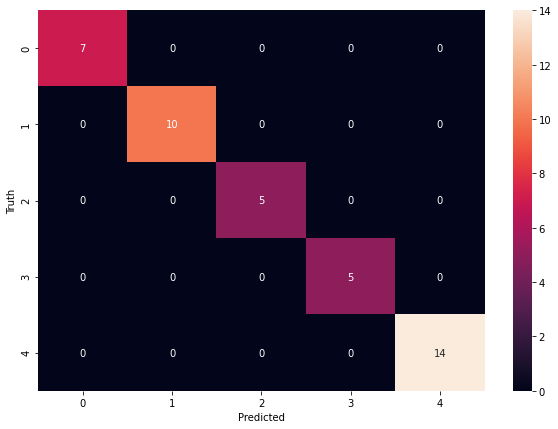

In [45]:
plt.figure(figsize = (10,7))
sn.heatmap(cm_svm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(69.0, 0.5, 'Truth')

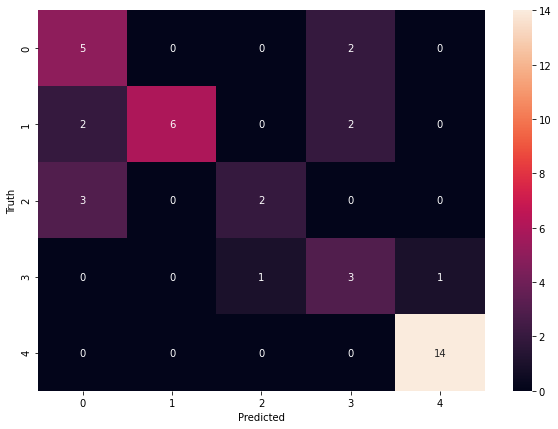

In [46]:
plt.figure(figsize = (10,7))
sn.heatmap(cm_random_forest, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(69.0, 0.5, 'Truth')

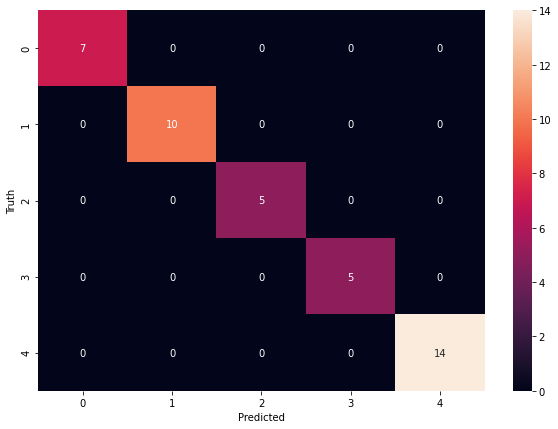

In [47]:
plt.figure(figsize = (10,7))
sn.heatmap(cm_logistic_regression, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [48]:
# Save the model as a pickle in a file 
joblib.dump(best_clf_svm, 'saved_model_svm.pkl') 

['saved_model_svm.pkl']

In [49]:
# Save the model as a pickle in a file 
joblib.dump(best_clf_random_forest, 'saved_model_random_forest.pkl') 

['saved_model_random_forest.pkl']

In [50]:
# Save the model as a pickle in a file 
joblib.dump(best_clf_logistic_regression, 'saved_model_logistic_regression.pkl') 

['saved_model_logistic_regression.pkl']

In [51]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))